## Instalación de Widgets Interactivos 

Instalamos la librería **`ipywidgets`**.
Esta herramienta es necesaria para crear **interfaces gráficas** dentro del propio Notebook (botones, menús desplegables, selectores). Más adelante, la usaremos para la herramienta de limpieza (`ImageClassifierCleaner`), que nos permitirá revisar y borrar manualmente las fotos malas haciendo clic en ellas, en lugar de escribir código.

In [1]:
!pip install ipywidgets

## Limpieza Automática de Imágenes Corruptas 

Descargar archivos de internet no es perfecto; a veces los archivos llegan incompletos o dañados. Este bloque se encarga de sanear nuestro dataset antes de empezar:

1.  **Verificación (`verify_images`)**: Usamos una herramienta de **FastAI** que intenta abrir cada imagen una por una. Si no puede abrirla, la marca como "fallida".
2.  **Eliminación Física**: El código recorre la lista de imágenes fallidas y usa `file.unlink()` para borrarlas permanentemente de tu disco duro.
3.  **Sincronización de Datos**: Si borramos un archivo del disco, también debemos borrar su nombre de nuestra tabla (`df`). Si no lo hiciéramos, más adelante el modelo intentaría leer un archivo que ya no existe y daría error.

In [3]:
# --- CÓDIGO DE LIMPIEZA AUTOMÁTICA ---
from fastai.vision.utils import verify_images
import os

# 1. Definimos dónde buscar
path_images = path/'images'

print(f"Escaneando carpeta: {path_images} ...")

# 2. FastAI revisa todas las imágenes
# Esto intenta abrir cada archivo. Si falla, lo marca como 'failed'.
failed = verify_images(get_image_files(path_images))

print(f"\nSe encontraron {len(failed)} imágenes corruptas.")

# 3. Borramos los archivos malos
for file in failed:
    print(f"--> Eliminando archivo corrupto: {file}")
    file.unlink() # Borrado físico del disco

# 4. Actualizamos la lista de datos (DataFrame)
# Quitamos de la lista 'df' cualquier archivo que hayamos borrado
if len(failed) > 0:
    print("Sincronizando la tabla de datos...")
    # Filtramos: solo dejamos las filas donde el archivo todavía existe
    df = df[df['fname'].apply(lambda x: (path/'images'/x).exists())]
    
print(f"\n¡Limpieza lista! Ahora tienes {len(df)} imágenes sanas.")

Escaneando carpeta: ..\data\images ...

Se encontraron 9 imágenes corruptas.
--> Eliminando archivo corrupto: ..\data\images\auto\4ded2fea-f0ed-4d76-b565-a9b1e672e080.jpg
--> Eliminando archivo corrupto: ..\data\images\auto\5254673e-3e71-4ddf-9703-22a9151f8a57.jpg
--> Eliminando archivo corrupto: ..\data\images\auto\9a5a0401-549e-44c1-bda9-1a700b9f4eb8.jpg
--> Eliminando archivo corrupto: ..\data\images\avion\37182614-9d09-458b-b7da-da1717a33ff3.jpg
--> Eliminando archivo corrupto: ..\data\images\avion\3dcb68f5-ab50-410a-9b58-76a03a9d621c.jpg
--> Eliminando archivo corrupto: ..\data\images\avion\78be211c-a399-4491-9c6f-386354a14b12.jpg
--> Eliminando archivo corrupto: ..\data\images\avion\a0b87281-2c62-4c10-984f-098d1068f8c2.jpg
--> Eliminando archivo corrupto: ..\data\images\avion\fa40d45b-af6c-426c-8538-c495c65ef3b4.jpg
--> Eliminando archivo corrupto: ..\data\images\barco\d70b4d5c-d979-4be4-a886-68e4cbe14eed.jpg
Sincronizando la tabla de datos...

¡Limpieza lista! Ahora tienes 272 i

## Preparación y Carga de Datos (DataBlock) 

En este bloque configuramos el "DataBlock", que es el plano arquitectónico de nuestros datos. Realizamos pasos críticos para que el entrenamiento funcione sin errores:

1.  **Filtro de Seguridad**: Antes de nada, revisamos el archivo CSV y eliminamos cualquier fila cuyo archivo de imagen ya no exista en el disco (por ejemplo, los que borramos en el paso de limpieza). Esto evita que el entrenamiento se detenga por errores de "Archivo no encontrado".
2.  **Funciones de Lectura**:
    * `obtener_imagen`: Le dice al modelo dónde buscar el archivo físico.
    * `obtener_etiquetas`: Le enseña a separar las etiquetas (ej: si dice "auto avion", entiende que son dos cosas distintas).
3.  **Configuración del DataBlock**:
    * **`MultiCategoryBlock`**: Especificamos que una imagen puede tener **múltiples etiquetas** a la vez (multilabel).
    * **`Splitter`**: Separamos automáticamente el 20% de las fotos para "Examen" (validación) y dejamos el 80% para estudiar (entrenamiento).
    * **`item_tfms` y `batch_tfms`**: Aplicamos una estrategia llamada **"Presizing"**. Primero redimensionamos las imágenes a un tamaño grande (460px) y luego aplicamos transformaciones (rotación, zoom, luz) reduciéndolas a 224px. Esto mejora la calidad final de los datos que ve la IA.
4.  **Visualización**: Al final, usamos `dls.show_batch()` para ver una muestra real con sus etiquetas sobreimpresas y confirmar que todo se cargó bien.

Imágenes válidas para entrenar: 272
Cargando imágenes... esto puede tardar unos segundos.

--- Visualización de Muestra ---


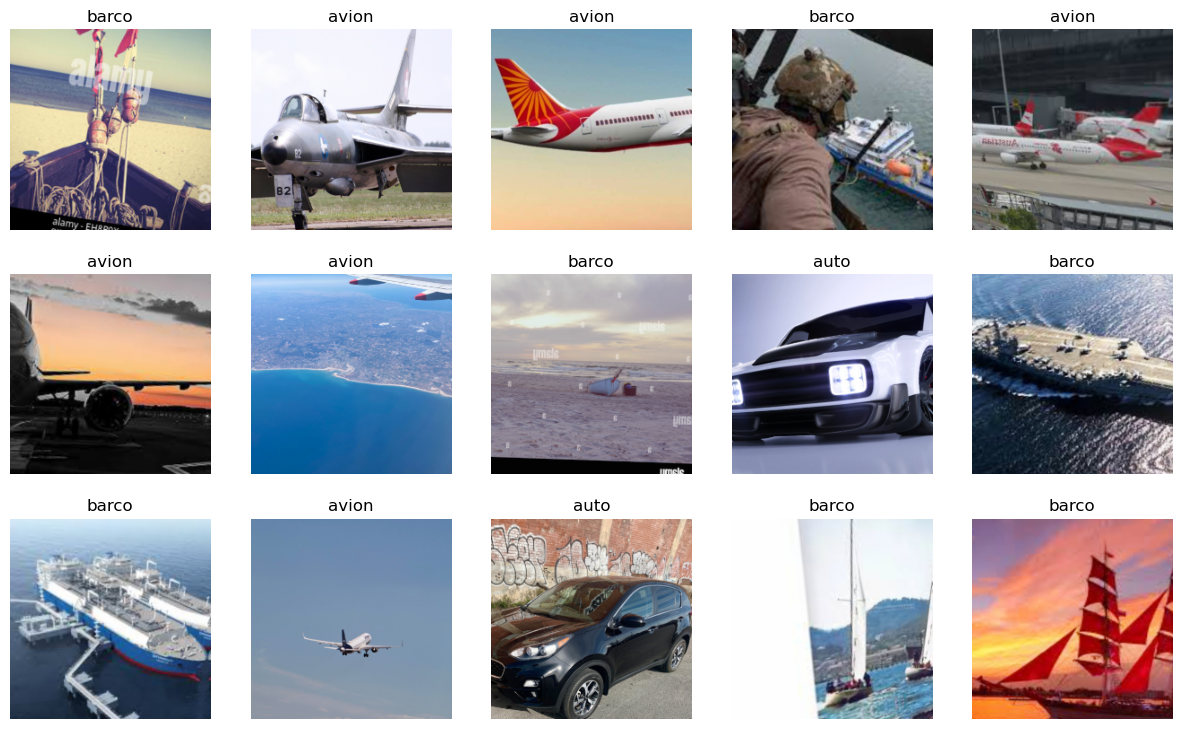

In [6]:
from fastai.vision.all import *
import pandas as pd

# 1. Cargar datos
path = Path('../data')
df = pd.read_csv(path/'labels.csv')

# --- PASO 1.5: FILTRO DE SEGURIDAD (IMPORTANTE) ---
# Esto elimina de la lista (df) cualquier archivo que hayas borrado del disco.
# Así evitamos errores de "File not found".
df = df[df['fname'].apply(lambda x: (path/'images'/x).exists())]
print(f"Imágenes válidas para entrenar: {len(df)}")

# --- CORRECCIÓN PARA WINDOWS ---
def obtener_imagen(fila):
    return path/'images'/fila['fname']

def obtener_etiquetas(fila):
    return fila['labels'].split(' ')

# 2. Construir el Cargador de Datos (DataBlock)
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=obtener_imagen,
    get_y=obtener_etiquetas,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

# Cargamos los datos
print("Cargando imágenes... esto puede tardar unos segundos.")
dls = dblock.dataloaders(df, bs=32)

# Muestra un lote de ejemplos (EDA Visual)
print("\n--- Visualización de Muestra ---")
dls.show_batch(max_n=15)

## Entrenamiento y Exportación del Modelo 

¡Llegamos al momento de la verdad! En este bloque ocurre el aprendizaje real:

1.  **Transfer Learning (ResNet18)**: No empezamos de cero. Usamos una red neuronal llamada **ResNet18** que ya sabe "ver" (fue entrenada con millones de imágenes). Nosotros solo le enseñamos la última capa para que distinga específicamente entre autos, barcos y aviones.
2.  **Ajuste para Windows**: La línea `learn.remove_cbs(ProgressCallback)` es un truco técnico. A veces, las barras de progreso animadas congelan Jupyter en Windows; al quitarlas, aseguramos que el entrenamiento llegue al final sin colapsar.
3.  **Fine Tune (Afinado)**: El comando `fine_tune(5)` adapta el cerebro de la IA a nuestros datos en 5 pasadas (epochs).
4.  **Exportación (`model.pkl`)**: Lo más importante. Al finalizar, guardamos todo lo aprendido en un archivo `.pkl`. **Este archivo es el que usará tu página web para funcionar.**

In [7]:
# --- ENTRENAMIENTO ROBUSTO ---
from fastai.callback.progress import ProgressCallback

# 1. Crear el cerebro (Learner)
# Usamos resnet18 (rápido y ligero)
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.5))

# TRUCO ANTIFALLOS: Quitamos la barra de carga visual para que no dé error en Windows
learn.remove_cbs(ProgressCallback)

print("Iniciando entrenamiento... (Se paciente, puede tardar unos minutos)")
print("El modelo está aprendiendo a distinguir Aviones, Autos y Barcos.")

# 2. Entrenar (Fine Tune)
# fit_one_cycle es la forma moderna de entrenar. Haremos 5 pasadas.
learn.fine_tune(5)

# 3. Ver resultados finales
print("\n--- Resultados ---")
# Mostramos la precisión final (accuracy_multi)
final_metric = learn.recorder.values[-1][-1] 
print(f"Precisión final estimada: {final_metric:.2%}")

# 4. Guardar el modelo
learn.export('model.pkl')
print("\n¡ÉXITO! Modelo guardado como 'model.pkl'.")
print("Ya puedes cerrar este notebook.")

Iniciando entrenamiento... (Se paciente, puede tardar unos minutos)
El modelo está aprendiendo a distinguir Aviones, Autos y Barcos.


C:\Users\alexc\anaconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0, 0.9022923707962036, 0.8599634766578674, 0.6419753432273865, '00:24']
[0, 0.4388073980808258, 0.3385813236236572, 0.8765431642532349, '00:27']
[1, 0.33544933795928955, 0.17021925747394562, 0.9259259104728699, '00:28']
[2, 0.2561395764350891, 0.14585793018341064, 0.9444444179534912, '00:27']
[3, 0.20597746968269348, 0.13787025213241577, 0.9444444179534912, '00:28']
[4, 0.1783369779586792, 0.13258999586105347, 0.9506173133850098, '00:27']

--- Resultados ---
Precisión final estimada: 95.06%

¡ÉXITO! Modelo guardado como 'model.pkl'.
Ya puedes cerrar este notebook.


## Instalación del Entorno Web 

Ahora que tenemos el modelo entrenado, cambiamos de "modo científico" a "modo desarrollador web". En esta celda instalamos las herramientas necesarias para levantar el servidor:

* **`fastapi`**: Es el cerebro de la aplicación. Nos permite crear las rutas (como `/predict` o `/teach`) para que la página web se comunique con Python.
* **`uvicorn`**: Es el motor. FastAPI no puede correr solo; necesita este servidor ligero y rápido para funcionar en tu computadora.
* **`python-multipart`**: Es el cartero. Esta librería es obligatoria para que FastAPI sea capaz de recibir **archivos** (las fotos) a través de formularios web. Sin ella, no podrías subir imágenes.

In [8]:
!pip install fastapi uvicorn python-multipart